In [66]:
import pandas as pd 
import missingno as msno 
import numpy as np 
import seaborn as sns
from datetime import datetime as dt 
import matplotlib.pyplot as plt
import plotly.express as px 
from dash import Dash, dcc, html, Input, Output
import sklearn 
from sklearn.linear_model import LinearRegression, Ridge, Lasso   
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import pickle 
from collections import OrderedDict



pd.options.display.max_columns = 150 
pd.options.display.max_rows = 150 

## Recuperation du CSV

In [67]:
df_modelisation = pd.read_csv('df2.csv')
df_modelisation_prix = df_modelisation[['price']]

### On supprime les colonnes qui nous semble inutile

In [68]:
df_modelisation = df_modelisation.drop('id', axis=1)
df_modelisation = df_modelisation.drop('date_sale', axis=1)
df_modelisation = df_modelisation.drop('price_log', axis=1)
df_modelisation = df_modelisation.drop('sqft_living15', axis=1)
df_modelisation = df_modelisation.drop('sqft_lot15', axis=1)

### On passe month et zipcode en objet 

In [69]:
data_types_dict = {'month': str} 
df_modelisation = df_modelisation.astype(data_types_dict)  

In [70]:
data_types_dict = {'zipcode': str} 
df_modelisation = df_modelisation.astype(data_types_dict)  

### Entraîner un algorithme de régression linéaire

### Séparation de features et target

In [71]:
X = df_modelisation.drop('price', axis=1)
y = df_modelisation[['price']]
X_train, X_test, y_train, y_test = train_test_split(X,y)
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)
my_num_pipe = make_pipeline(StandardScaler(), PolynomialFeatures())
preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(),cat_col),
    ("scaling", my_num_pipe, num_col)
])


In [72]:
list(num_col)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'year']

In [73]:
list(cat_col)

['zipcode', 'month']

In [74]:
preprocessing = ColumnTransformer(transformers=[('one_hot', OneHotEncoder(), cat_col),
                                ('scaling', StandardScaler(), num_col)])                              

# LINEAR REGRESSION   LR

In [75]:
my_pipe_lr = make_pipeline(preprocessing, LinearRegression())

In [76]:
my_pipe_lr = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', LinearRegression())
    ]
)

### Fit - Score - Predict

In [77]:
my_pipe_lr.fit(X_train, y_train)
print ("my_pipe_lr score : " , my_pipe_lr.score(X_test, y_test))
print ("my_pipe_lr predict : " , my_pipe_lr.predict(X_train))

my_pipe_lr score :  0.818063024153158
my_pipe_lr predict :  [[ 895405.39009931]
 [ 365634.03269334]
 [ 607139.51554045]
 ...
 [ 440548.40095838]
 [1610670.27339348]
 [ 339773.20121553]]


## Learning curve: courbe d'apprentissage

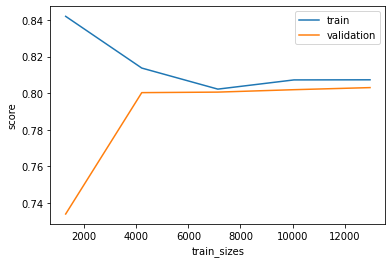

In [78]:
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(my_pipe_lr,X_train,y_train,return_times=True)
                                   
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.legend()
plt.show()



## SUPPRIMER LES VALEURS INFLUENTES 

In [79]:
y_pred = my_pipe_lr.predict(X_train)
y_pred.reshape(1,16209)
y_pred

array([[ 895405.39009931],
       [ 365634.03269334],
       [ 607139.51554045],
       ...,
       [ 440548.40095838],
       [1610670.27339348],
       [ 339773.20121553]])

In [80]:
y_train

,price
5631,720000.0
13166,379880.0
18493,689800.0
4766,490000.0
466,465000.0
...,...
5647,619950.0
11105,1820000.0
1926,255000.0
9553,1795000.0


In [81]:
residual = (y_pred-y_train).abs().sort_values(by='price', axis= 0 , ascending= False)
residual

,price
7252,4.350165e+06
3914,3.379418e+06
9254,3.167774e+06
1448,2.527102e+06
12370,2.266880e+06
...,...
10702,3.555987e+01
6118,3.468341e+01
9842,3.339869e+01
2330,2.642811e+01


In [82]:
to_drop = residual[residual > 500000].index
df_cleaned = df_modelisation.drop(to_drop)   
df_cleaned = df_cleaned.drop('price', axis=1)
df_cleaned

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,year,month
12,3,1.00,1430,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,2014,5
13,3,1.75,1370,9680,1.0,0,0,4,7,1370,0,1977,0,98074,47.6127,-122.045,2014,10
14,5,2.00,1810,4850,1.5,0,0,3,7,1810,0,1900,0,98107,47.6700,-122.394,2015,3
15,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2015,1
20,4,1.75,1620,4980,1.0,0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,2014,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,2,2.25,1530,981,3.0,0,0,3,8,1480,50,2006,0,98103,47.6533,-122.346,2014,10
21600,5,3.75,4470,8088,2.0,0,0,3,11,4470,0,2008,0,98004,47.6321,-122.200,2014,10
21601,3,2.50,1425,1179,3.0,0,0,3,8,1425,0,2008,0,98125,47.6963,-122.318,2015,4
21605,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2014,10


## Entraîner un algorithme de régression linéaire

In [83]:
X = df_modelisation.drop('price', axis=1)
y = df_modelisation[['price']]
X_train, X_test, y_train, y_test = train_test_split(X,y)
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)
my_num_pipe = make_pipeline(StandardScaler(), PolynomialFeatures())
preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(),cat_col),
    ("scaling", my_num_pipe, num_col)
])

In [84]:
my_pipe_lr = make_pipeline(preprocessing, LinearRegression())

In [85]:
my_pipe_lr = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', LinearRegression())
    ]
)

### Fit - Score - Predict

In [86]:
my_pipe_lr.fit(X_train, y_train)
print ("my_pipe_lr score : " , my_pipe_lr.score(X_test, y_test))
print ("my_pipe_lr predict : " , my_pipe_lr.predict(X_train))

my_pipe_lr score :  0.868453863316927
my_pipe_lr predict :  [[622473.125]
 [364729.375]
 [610741.375]
 ...
 [262387.125]
 [295755.875]
 [493945.125]]


## Stocker le modèle de régression choisi à l'aide du module pickle 

In [88]:
my_pipe_lr
with open("my_pipe_lr.pkl", "wb") as f:
    pickle.dump(my_pipe_lr, f)

def load_from_pickle(name):
    with open(name, "rb") as f:
        return pickle.load(f)


In [89]:
load_from_pickle("my_pipe_lr.pkl")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['zipcode', 'month']),
                                                 ('scaling',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'lat',
                                                   'long', 'year'])])),
                ('ridge', LinearRegression())])

# RIDGE

### Pipeline

In [90]:
my_pipe_ridge = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('ridge', Ridge())
    ]
)

### Recherche des meilleurs paramètres 

In [91]:
my_pipe_ridge.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                    ['zipcode', 'month']),
                                   ('scaling',
                                    Pipeline(steps=[('standardscaler',
                                                     StandardScaler()),
                                                    ('polynomialfeatures',
                                                     PolynomialFeatures())]),
                                    ['bedrooms', 'bathrooms', 'sqft_living',
                                     'sqft_lot', 'floors', 'waterfront', 'view',
                                     'condition', 'grade', 'sqft_above',
                                     'sqft_basement', 'yr_built', 'yr_renovated',
                                     'lat', 'long', 'year'])])),
  ('ridge', Ridge())],
 'verbose': False,
 'preprocessing': ColumnTransformer(transformers=[('one_hot', OneHot

In [92]:
hyperparametres = {'ridge__alpha': [0.01,0.1, 0.2,0.5, 1,10]}

In [93]:
random_search = GridSearchCV(my_pipe_ridge, hyperparametres, cv= 5)
random_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['zipcode',
                                                                          'month']),
                                                                        ('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors',
                                                                          'waterfront',
                                                                          'view',
                                                                          'condition',
                                                                          'grade',
                                                                          'sqft_above',
                                                                          'sqft_basement',
                                                                          'yr_built',
                                                                          'yr_renovated',
                                                                          'lat',
                                                                          'long',
                                                                          'year'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 0.2, 0.5, 1, 10]})

In [94]:
random_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(),
                                                                         ['zipcode',
                                                                          'month']),
                                                                        ('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['bedrooms',
                                                                          'bathrooms',
                                                                          'sqft_living',
                                                                          'sqft_lot',
                                                                          'floors',
                                                                          'waterfront',
                                                                          'view',
                                                                          'condition',
                                                                          'grade',
                                                                          'sqft_above',
                                                                          'sqft_basement',
                                                                          'yr_built',
                                                                          'yr_renovated',
                                                                          'lat',
                                                                          'long',
                                                                          'year'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 0.2, 0.5, 1, 10]})

In [95]:
random_search.best_params_

{'ridge__alpha': 0.01}

In [96]:
my_pipe_ridge.set_params(**random_search.best_params_)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['zipcode', 'month']),
                                                 ('scaling',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('polynomialfeatures',
                                                                   PolynomialFeatures())]),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'waterfront',
                                                   'view', 'condition', 'grade',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'yr_renovated', 'lat',
                                                   'long', 'year'])])),
                ('ridge', Ridge(alpha=0.01))])

### Fit - Score - Predict

In [97]:
my_pipe_ridge.fit(X_train, y_train)
print ("my_pipe_ridge score : " , my_pipe_ridge.score(X_test, y_test))
print ("my_pipe_ridge predict : " , my_pipe_ridge.predict(X_train))

my_pipe_ridge score :  0.8684567418265817
my_pipe_ridge predict :  [[622462.36982894]
 [364672.90581487]
 [610696.35013657]
 ...
 [262375.22081649]
 [295811.76245427]
 [493946.95592506]]


# LASSO

### Pipeline

In [98]:
my_pipe_lasso = make_pipeline(preprocessing, Lasso())

In [99]:
my_pipe_lasso = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('lasso', Lasso())
    ]
)

### Fit - Score - Predict

In [100]:
my_pipe_lasso.fit(X_train, y_train)
print ("my_pipe_lasso score : " , my_pipe_lasso.score(X_test, y_test))
print ("my_pipe_lasso predict : " , my_pipe_lasso.predict(X_train))

my_pipe_lasso score :  0.8687212165630084
my_pipe_lasso predict :  [622691.32030318 364634.40797494 611431.69130913 ... 262013.62895431
 297130.99105909 494224.91996304]


/home/kahoul/miniconda3/envs/ykp/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+14, tolerance: 2.203e+11
  model = cd_fast.enet_coordinate_descent(


# ELASTIC NET 

### Pipeline

In [101]:
my_pipe_elastic_net = make_pipeline(preprocessing, ElasticNet())

In [102]:
my_pipe_elastic_net = Pipeline(
    [
        ("preprocessing", preprocessing), 
        ('elastic_net', ElasticNet())
    ]
)

### Fit - Score - Predict

In [103]:
my_pipe_elastic_net.fit(X_train, y_train)
print ("my_pipe_elastic_net score : " , my_pipe_elastic_net.score(X_test, y_test))
print ("my_pipe_elastic_net predict : " , my_pipe_elastic_net.predict(X_train))

my_pipe_elastic_net score :  0.7501224119867029
my_pipe_elastic_net predict :  [642889.34412897 420956.71678035 674752.51571972 ... 358222.12993299
 413651.28226653 488895.45026601]


## Comparaison des modèles

In [104]:
modeles = { 
"my_pipe_lr.score" : my_pipe_lr.score(X_test, y_test), "my_pipe_elastic_net.score ": my_pipe_elastic_net.score(X_test, y_test),
"my_pipe_lasso.score" : my_pipe_lasso.score(X_test, y_test), "my_pipe_ridge.score" : my_pipe_ridge.score(X_test, y_test)
}

modeles = sorted(modeles.items(), key=lambda x: x[1])
modeles

[('my_pipe_elastic_net.score ', 0.7501224119867029),
 ('my_pipe_lr.score', 0.868453863316927),
 ('my_pipe_ridge.score', 0.8684567418265817),
 ('my_pipe_lasso.score', 0.8687212165630084)]

In [105]:
df_cleaned.to_csv("df_cleaned.csv")  

In [106]:
df_modelisation_price = df_modelisation["price"]
df_modelisation_price.to_csv("df_modelisation_price.csv")

## Modélisation de la méthode de régression linéaire

In [107]:
""" plt.scatter(X, y)
plt.plot(X, model.predict(X), c='red') """

" plt.scatter(X, y)\nplt.plot(X, model.predict(X), c='red') "

In [108]:
""" plt.plot(df_modelisation2 , df_modelisation_prix,'ro', markersize = 4) #UTILISATION DE LA FONCTION PLOT 
plt.show() """


" plt.plot(df_modelisation2 , df_modelisation_prix,'ro', markersize = 4) #UTILISATION DE LA FONCTION PLOT \nplt.show() "

In [109]:
""" predictions = model.predict(X_test)
plt.scatter(X_test,y)
plt.plot(X, predictions, c='r') """

" predictions = model.predict(X_test)\nplt.scatter(X_test,y)\nplt.plot(X, predictions, c='r') "

## Fonction qui permet de prédire le prix d'une maison

In [110]:
""" def prediction_maison(model,sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023):
    x = np.array([sqft_living	,grade	,sqft_above	,sqft_living15	,bathrooms,	view	,sqft_basement	,
                bedrooms	,zipcode_98004	,waterfront	,floors	,zipcode_98039,	zipcode_98040	,zipcode_98112,	zipcode_98006,	yr_renovated	,
                zipcode_98033,	zipcode_98105	,sqft_lot,	zipcode_98075,	zipcode_98199	,
                sqft_lot15 ,	zipcode_98001,	zipcode_98042,	zipcode_98023]).reshape(1,25)
    print (model.predict(x)) """


' def prediction_maison(model,sqft_living\t,grade\t,sqft_above\t,sqft_living15\t,bathrooms,\tview\t,sqft_basement\t,\n                bedrooms\t,zipcode_98004\t,waterfront\t,floors\t,zipcode_98039,\tzipcode_98040\t,zipcode_98112,\tzipcode_98006,\tyr_renovated\t,\n                zipcode_98033,\tzipcode_98105\t,sqft_lot,\tzipcode_98075,\tzipcode_98199\t,\n                sqft_lot15 ,\tzipcode_98001,\tzipcode_98042,\tzipcode_98023):\n    x = np.array([sqft_living\t,grade\t,sqft_above\t,sqft_living15\t,bathrooms,\tview\t,sqft_basement\t,\n                bedrooms\t,zipcode_98004\t,waterfront\t,floors\t,zipcode_98039,\tzipcode_98040\t,zipcode_98112,\tzipcode_98006,\tyr_renovated\t,\n                zipcode_98033,\tzipcode_98105\t,sqft_lot,\tzipcode_98075,\tzipcode_98199\t,\n                sqft_lot15 ,\tzipcode_98001,\tzipcode_98042,\tzipcode_98023]).reshape(1,25)\n    print (model.predict(x)) '

In [111]:
""" #essai de la fonction
prediction_maison(model,50,7,30,48,2,2,0,2,1,0,1,0,0,0,0,1988,0,0,35,0,0,40,0,0,0) """

' #essai de la fonction\nprediction_maison(model,50,7,30,48,2,2,0,2,1,0,1,0,0,0,0,1988,0,0,35,0,0,40,0,0,0) '